# Assigment 6: dimensionality reduction and clustering

In [1]:
%pylab inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr

Populating the interactive namespace from numpy and matplotlib


In previous assigments, you have familiarized with data analysis techniques that allow to model or predict the response of the neural population to a certain stimulus (neural coding), or to predict the identity of some external feature (e.g. the poisiton of the animal or the presence of a stimulus) by looking at the neural activity (decoding).
These are examples of **supervised learning** methods: they aim to learn the relationship between some data X and some "labels" Y.
In this assignment we will introduce some techniques for **unsupervised learning**. In this case, no labels are present to supervise our learning procedure, and our aim is to describe the structure of the data X alone.  
We will look at a couple of simple but paradigmatic methods for finding structure in data: in the first part we will look at **Principal component analysis (PCA)**, in the second we will introduce a couple of **clustering** techinques.  
For the code implementation we will be using scikit-learn (https://scikit-learn.org/stable/), a powerful python library for machine learning and data analysis.

# 1. Principal Component Analysis (PCA)

Principal component analysis is one of the most popular dimensionality reduction algorithms. It performs **linear orthogonal transformation** of the data space that finds the combinations of features that best explain the variability of the data. These combinations, called **principal components**, form a new coordinate system for the data, such that the coordinates are ranked by explained variance.  

Here is a brief overview of how PCA works:  
Let's consider a $N\times P$ data matrix $X$ with $P$ features and $N$ observations (often referred to as "samples" in the data science literature).  
These are $N$ points $x_{i}$ in a  $P$-dimensional space.  

To find the first principal component, the algorithm looks for a $P$-dimensional weight vector $w_{1}$, with unit norm ($|w_{1}=1|$), such that the sum of the projections of the $N$ observed points $x_{i}$ in the direction $w_{1}$ is maximal:

$$ w_{1}=\underset{|w|=1} {argmax}\left[  \sum_{i=1}^{N}(x_{i} \cdot w)^{2} \right] = \underset{|w|=1} {argmax}\left[ w^{T}X^{T}Xw \right] $$

This finds the first principal component $w_{1}$, i.e. the direction of maximal variability in the feature space.  
We can repeat the procedure to find a second direction $w_{2}$, that maximizes variability on the $P-1$ dimensional subspace  $\hat{X}$ orthogonal to $w_{1}$.
We first find $\hat{X}$ by subtracting the first principal component from $X$:

$$ \hat{X}= X -Xw_{1}w_{1}^{T} $$

And then find $w_{2}$ maximizig projections in $\hat{X}$:

$$ w_{2} = \underset{|w|=1} {argmax}\left[ w^{T}\hat{X}^{T}\hat{X}w \right] $$

Repeating the procedure, we can iteratively found an orthonormal basis for the features space, in which dimensions are ranked by how variable the observed data are along them.
This ranking can be used to reduce the dimensionality of the data: we can decide to retain only the first $L$ components ($L<P$), we obtain a $L$ dimensional description of $X$. The PCA procedure guarantees that this representation i the one that captures the most variance of the data, given $L$.

Let's look now at an illustrative example, on simulated data, to see how we can use PCA to uncover a low dimensional structure in the dynamics of a population of many neurons.

## Example: PCA for dimensionality reduction of neural dynamics

Suppose that your data X is a matrix representing the average firing rate in a 100 ms window of a population of 50 neurons, for an observation time of 100 seconds.  
In this case we have $N=1000$ samples and $P=50$ features (the firing rate of each neuron).
We import this dataset, generated from simulated data, from the file "pca_example.npy".

In [2]:
firing_rate = np.load("PCA_example.npy")

We can plot the firing rate of the neurons over time:

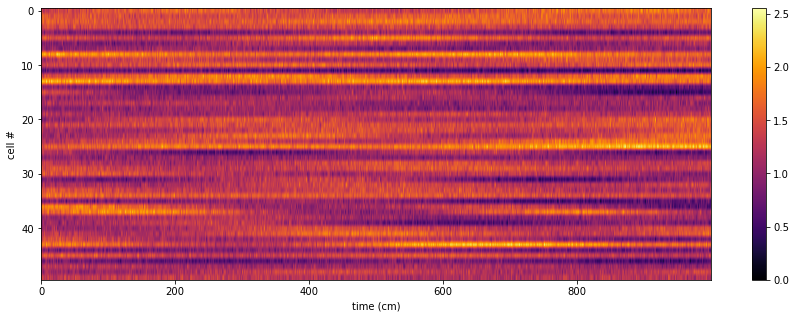

In [3]:
figure(figsize=(15, 5))
imshow(firing_rate,cmap=cm.inferno, aspect='auto')
plt.xlabel('time (cm)')
plt.ylabel('cell #')
plt.colorbar();

The population activity lives in a 50 dimensional space, spanned by the firing rate of each of the recorded neurons.  
However, these neurons are not necessarely independent: they can receive common input, or interact with one another. This means that the activity might actually live in a subspace of lower (possibly much lower) dimension with respect to the original space.
Let's now apply PCA to this dataset, to see if we can reduce its dimensionality and obtain a more compact description of the population activity.

First, we z-transform the data, such that each neuron has zero mean and unit variance.  
We use the StandardScaler class from scikit learn (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). This is to make sure that any effect we find is not driven by the variability of few neurons with very large firing. In this simulated dataset, all neurons have comparable average activity, but this is ofthen not the case in recored data.

In [4]:
scaler = StandardScaler();                #defines a scaler object
X = scaler.fit_transform(firing_rate.T)   # uses the fit_transform() method to fit the data (calculate mean and standard deviation of the firing of each neuron), and z-transform them

We are now ready to run the PCA algorithm on the dataset.  
Firts, we define a pca object from the scikit learn PCA class (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). 
Then we call the fit() method: this will find the PCs and their eigenvalues, which are proprotional to the amount of variance explained by each PC.
We can plot the explained variance ratio (EVR) for each component, and the cumulative EVR as a function of the number of retained components.

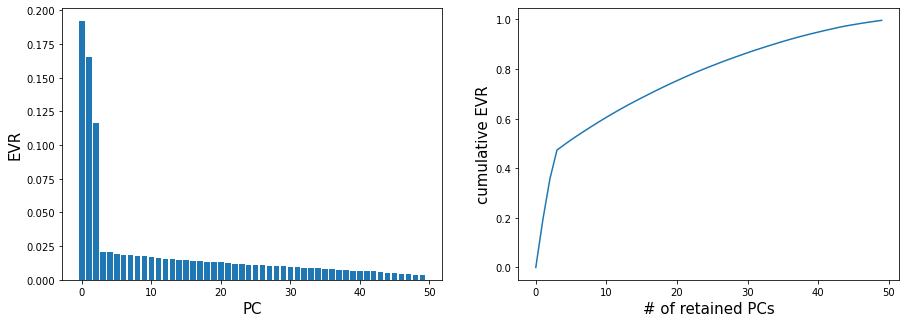

In [7]:
pca = PCA();
pca.fit(X);

figure(figsize(15,5))
ax1 = subplot(1,2,1)
ax1.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
ax1.set_xlabel("PC",fontsize=15);
ax1.set_ylabel("EVR",fontsize=15);

ax2 = subplot(1,2,2)
cumulative_EVR=[sum(pca.explained_variance_ratio_[:i]) for i in range(len(pca.explained_variance_ratio_))]
ax2.plot(range(len(pca.explained_variance_ratio_)),cumulative_EVR)
ax2.set_xlabel("# of retained PCs",fontsize=15);
ax2.set_ylabel("cumulative EVR",fontsize=15);

We see that the first three PCs alone explain roughly 50% of the variance of the data. Moreover, in this case there is a sharp drop in the EVR after PC3 (this drop also shows in the elbow in the cumulative EVR). We can use this information to reduce the dimensionality of the data by projecting them onto the 3D subspace spanned by the first 3 PCs. We do that with the fit_transform() method fo the scikit-learn PCA class.

Text(0.5, 0, 'PC 3')

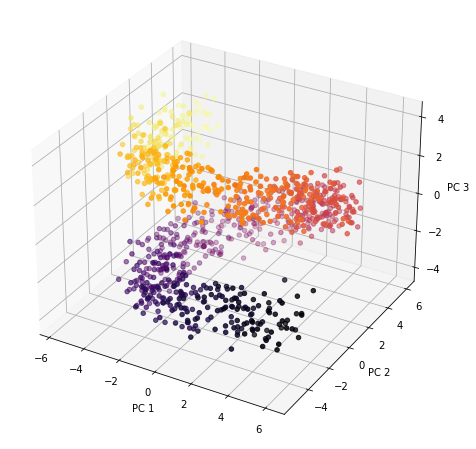

In [10]:
pca = PCA(n_components=3)                       # this PCA model will retain only the first 3 components
pca_results = pca.fit_transform(X);  # fit_transform() finds the n_components principal components and projects the data along them
x = pca_results.T[0]
y = pca_results.T[1]
z = pca_results.T[2]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d') 
ax.scatter(x, y, z,c=arange(len(x)),cmap=cm.inferno)  # let's color the datapoints with their time, to visualize the temporal evolution of the population dynamics 
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

The PCA uncovered some structure in the data: the population dynamics evolves by rotating around the PC3 axis and progressively increasing its PC3 coordinate.  

To better understand this 3D evolution, let's look at the code that generated this particular dataset:

In [5]:
from scipy.stats import ortho_group
N = 50
R = ortho_group.rvs(N)          #this function generates a random rotation matrix in an N dimensional space
T = linspace(0,60,1000)
A = np.random.rand(len(T),N)*0.5
activity = np.zeros((len(T),N))
for t in range(len(T)):
    theta = T[t]/(2*pi)
    A[t][0] += cos(theta)
    A[t][1] += sin(theta)
    A[t][2] += 0.2*theta
    activity[t] = matmul(R,A[t])

**Question 1**. What does this code do? How would you tweak the code to change the velocity at which the activity rotates? And the vertical drift speed? Write down your answers.

**Question 2**: Use the code to generate other two dynamics, one halving and another doubling the noise. Plot at the EVR and cumulative EVR in this two cases. How does it change? (Hint: the noise is injected in the code when the array that will contain the activity is generated)

**Question 3**: we can see from the code that generated it (and from the 3D scatterplot) that the population activity actually lives (a part from the noise component), on a 1D trajectory.  
This trajectory is parametrized by an intrinsic coordinate, in this case coinciding with the time $t$:  
$PC1(t)=cos(t/2\pi)$  
$PC2(t)=sin(t/2\pi)$  
$PC3(t)=0.2t$  
The PC1 found by the PCA algorithm does NOT correspond to this intrinsic coordinate. Why do you think this is the case? 

**Question 4**: import the dataset "pca_exercise.npy", that contains a different neural population dynamics. Plot the firing rate maps of the neurons. 
Use PCA to find and plot the EVR of the different principal components. What number of dimension would you retain to describe this data? Why?

**Question 5**: visualize the population dynamics in the relevant PC subspace. What shape does it have? Do you think there could be an even lower-dimensional description of the population activity? 

# 2. CLUSTERING

Clustering, also called "data segmentation", refers to a variety of techniques that aim to reduce the dimensionality of the data by grouping them into clusters, such that elements within each cluster are more similar to each other than elements from different clusters.  
Here we will introduce a couple of algorithms that illustrate two of the most popular approaches to clustering.

First lest's look at two example datasets in which each datapoint lives in a two dimensional feature space ($P=2$).

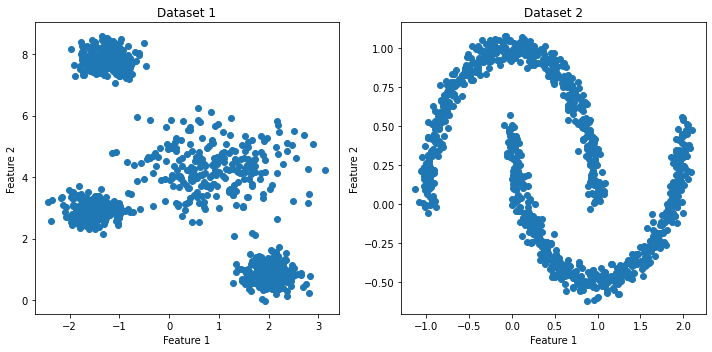

In [11]:
X1 = np.load("clustering_example_1.npy")
X2 = np.load("clustering_example_2.npy")
figure(figsize=(10,5))
subplot(1,2,1)
scatter(X1.T[0],X1.T[1])
title("Dataset 1")
xlabel("Feature 1")
ylabel("Feature 2")
subplot(1,2,2)
scatter(X2.T[0],X2.T[1])
title("Dataset 2")
xlabel("Feature 1")
ylabel("Feature 2")
tight_layout()

Clearly, there is some structure here. The data is organized in 4 different clusters in the first dataset, and in two, moon-shaped clusters in the second. Clustering algorithms aim to automatically detect these structures in the data.

## K-means: distance based clustering

K-means is one of the most famous distance-based clustering algorithm. It takes as a parameter the number of cluster in which the data have to be divided into, and segments them by assinging each point to the nearest cluster centroid.   
The algorithm roughly works as follows:  
0- **Intitialization**:  randomly chose  K cluster centroids in the feature space, and assign each data point to the closest cluster.  
1- **Update**: calculate the center of mass of the point belonging to each cluster and assign them as the new centroids.  
2- **Assignment**: assign each point to the closest cluster.  
Repeat 1 and 2 until convergence (i.e. the assignments do no longer change)

We can use the scikitlearn Kmeans class (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to run the Kmeans algorithm on these two datasets. We specify the number of clusters: 4 for the fist dataset, 2 for the second. After fitting the data with the fit() method, we can plot the cluster centers the algorithm found, and plot the data color-coded with the assigned labels.

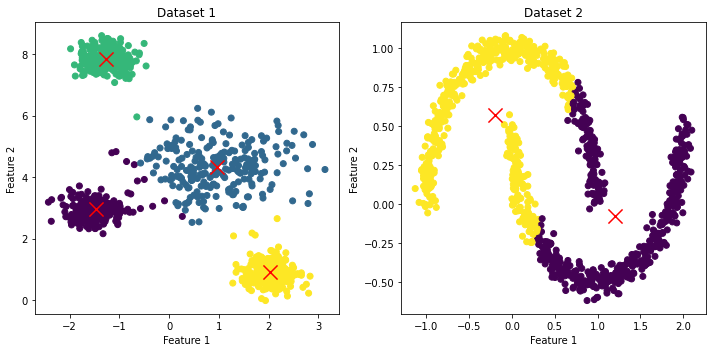

In [12]:
figure(figsize=(10,5))
subplot(1,2,1)
title("Dataset 1")
xlabel("Feature 1")
ylabel("Feature 2")
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X1)
scatter(X1.T[0],X1.T[1],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], marker='x', c="r",s=200)

subplot(1,2,2)
title("Dataset 2")
xlabel("Feature 1")
ylabel("Feature 2")
kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X2)
scatter(X2.T[0],X2.T[1],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], marker='x', c="r",s=200)
tight_layout()

As you can see, the method works well on the first dataset, identifying the four cluters and their centroids. On the second one, however, the methods fail to give us the division we would expect, even if we know a priori the right number of clusters to look for. This is because the Kmeans algorithm is **distance based**, and works well only if the clusters are spherical. With the moon-shaped clusters of the second dataset, we will have to use a different approach: density based clustering.

## DBSCAN: density base clustering

DBSCAN is an example of **density based** clustering algorithms. This methods look for region of high density in the data space, and allot them as clusters, separated by low density regions.  
DBSCAN does not need the user to specify the number of clusters, that is found authomatically by the algorithm. Instead, a distance scale $\epsilon$ and a minimun number of neighours $minPts$ are required, in order for the algorithm to know what is "dense". 

Given $\epsilon$ and $minPts$, the DBSCAN algorithm procedes with the following steps:  
1- For each datapoint $i$, count how many other points are within distance $\epsilon$. These points define the neighbourhood of $i$  
2- If datapoint $i$ has more than $minPts$ in its neighbourhood, it is a core point.  
3- All datapoints in the neighbour of a core datapoint are assigned to the same cluster. This steps finds the connected component of the neighbour graph, and each connected component is assigned to a cluster.  
4- Each non-core point that is not assigned to a cluster in point in step 3 is labeled as an outlier. It does not belong to any cluster.  

Let's use the scikit-learn class DBSCAN (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) on dataset 2. We will see the effect of different $\epsilon$ on the result we obtain.

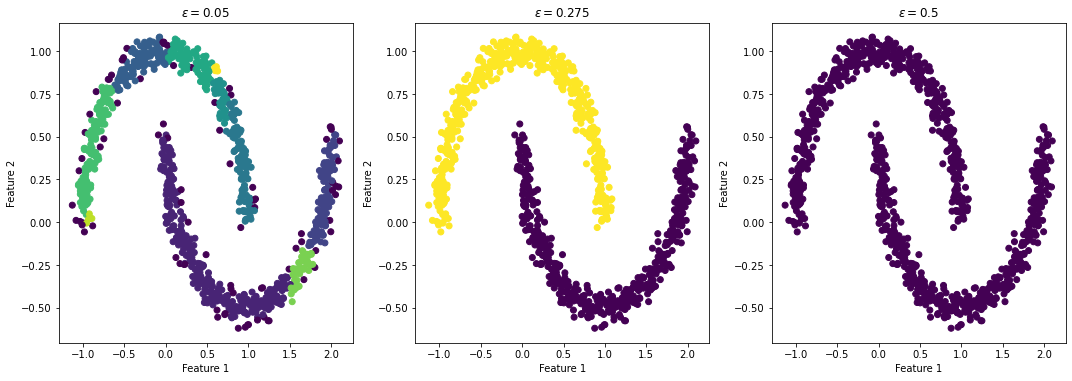

In [29]:
figure(figsize=(15,10))
epsilons = linspace(0.05,0.5,3)
for i in range(len(epsilons)):
    subplot(2,len(epsilons),i+1)
    title("$\epsilon=$"+str(epsilons[i]))
    xlabel("Feature 1")
    ylabel("Feature 2")
    dbscan=DBSCAN(eps=epsilons[i],min_samples=5)
    
    dbscan.fit(X2)
    scatter(X2.T[0],X2.T[1],c=dbscan.labels_)
tight_layout()

You can see how the clustering depends on the scale $\epsilon$: a too small $\epsilon$ breaks the structure in too many clusters, a too large one does not dicriminate them.  
Now let's see how DBSCAN behaves on Dataset 1.

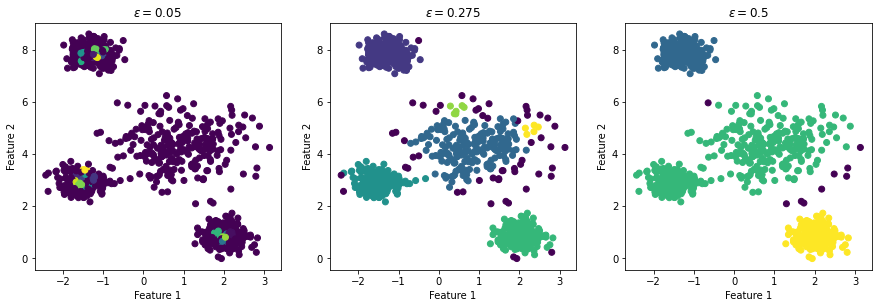

In [13]:
figure(figsize=(15,10))
epsilons = linspace(0.05,0.5,3)
for i in range(len(epsilons)):
    subplot(2,len(epsilons),i+1)
    title("$\epsilon=$"+str(epsilons[i]))
    xlabel("Feature 1")
    ylabel("Feature 2")
    dbscan=DBSCAN(eps=epsilons[i],min_samples=5)
    dbscan.fit(X1)
    scatter(X1.T[0],X1.T[1],c=dbscan.labels_)

Here DBSCAN fails to detect the four clusters.

**Question 6.** Why do you think it is the case? What feature of the dataset prevents the algorithm to work well?

## Cluster metrics

The choice of parameters for clustering algorithms depends on what we want to look at, and in general there is no such a thing as "the correct set of parameters". There are, however, some metrics we can use to see if the choices we are making make sense. Many metrics are available for this purpose. Here, we will look at two widely used ones: **inertia** (or within-cluster distance) adn the **silhouette score**.

### Inertia (within-cluster distance)

Inertia is defined as the sum of all the distances of the data points from their cluster centroids 

$$ I= \sum_{i=1}^{N} d(i, c(i))$$

The lower $I$, the better the clustering. Since $I$ is monotonically decreasing with the number of clusters, it cannot be used by itself to determine a good value of K for the k-means algorithm. Instead, we can look at $I(K)$ for a flexion point (or elbow), that signals a decreased improvement in clustering performance with the addition of more clusters: this could be a good point to stop adding clusters.


### Silhouette coefficient

The silhouette is calculated, for every data point $i$ as the normalized difference between the average within-cluster distance $a(i)$ and the smaller between-cluster distance $b(i)$.   

$$ a(i)=\frac{1}{|C_{i}-1|}\sum_{j \in C_{i},j \neq i} d(i,j)$$ 
$$ b(i)=\underset{k \neq i}{min}\frac{1}{C_{k}}\sum_{j \in C_{k}} d(i,j)$$
$$s(i)=\frac{b(i)-a(i)}{max[a(i),b(i)]}$$  
It ranges from -1 to 1, with high values indicating well separated clusters.  
The silhouette coefficient, obtained by averaging the silhouette values on all the dataset, is a global metric of clustering quality, and can be used to select good values for the parameters of the clustering algorithm.  

Let's see what these two metrics say on the Kmeans performance on dataset 1: we fit k-means on the data, varying the number $K$ of clusters we want. We look at how intertia and the silhouette score change as a function of $K$.

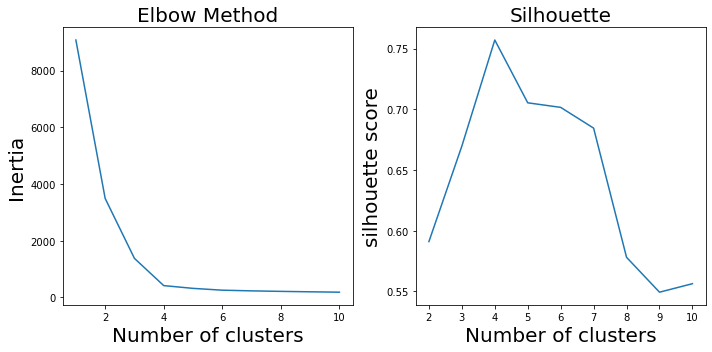

In [83]:
figure(figsize=(10,5))

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(X1)
    inertia.append(kmeans.inertia_)
subplot(1,2,1)
plot(range(1, 11), inertia)
title('Elbow Method',fontsize=20)
xlabel('Number of clusters',fontsize=20)
ylabel('Inertia',fontsize=20)


s_score = []
for i in range(2,11):      # note that we start from 2: the silhouette is not defined for a single cluster
    kmeans = KMeans(n_clusters=i, init='k-means++')
    labels = kmeans.fit_predict(X1)
    s_score.append(silhouette_score(X1,labels))

subplot(1,2,2)
plot(range(2,11), s_score)
title('Silhouette' ,fontsize=20)
xlabel('Number of clusters',fontsize=20)
ylabel('silhouette score',fontsize=20)

tight_layout()

We can see, from the ellbow on the left and the peak on the right, that indeed 4 clusters seems to be the best choice for the k-means algorithm.

**Question 7**. Apply these metrics to the Kmeans algorithm on dataset 2. What is the best number of clusters in this case? Are these metrics alone a reliable indicator that our clustering approach is the right one?

**Question 8**. Import the dataset X3 from the file "clustering_exercise_1", and plot the data in the feature space. How many clusters do you think best describe the data? Use the two metrics we have introduced to support your intuition. Plot both metrics as a function of the number of clusters used in the Kmeans algorithm.

**Question 9**. Use the best number of clusters you determined in Question 8 to fit the X3 data. Plot the data color-coded by cluster label and the cluster centroids.

**Question 10**. Now import the data from "clustering_exercise_2.npy". This data comes from the same distribution as X3. Use the Kmeans model you fitted on X3 to assign each of the new data points to one of the clusters you determined in Question 9 (Hint: use the predict() method). Save the labels in an array called label_predictions, and plot the new points, color coded by their cluster labels. 

## Example:  Detecting coactive cell assemblies with K-means clustering

Let's now see how we can use clustering methods to detect assemlies of cells that tend to activate together. 
Let's import the dataset "assemblies_example.npy", representing the activity of 100 simulated neurons, sampled every 10 milliseconds for 100 seconds.

In [288]:
population_vector=np.load("assemblies_example.npy")

population_vector is a $100 \times 10000$ matrix, whose entries represent the count of spikes emitted by each neuron at each given time. Let's plot it.

Text(0, 0.5, 'neuron #')

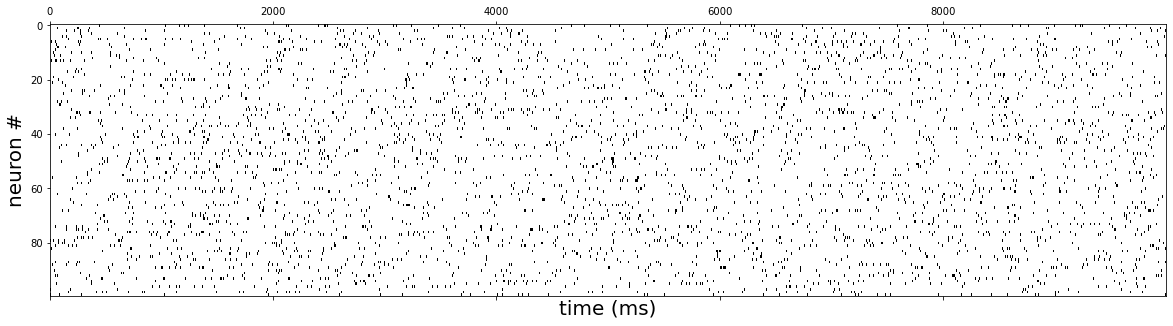

In [289]:
fig, ax = plt.subplots(figsize=(20,5))
ax.matshow(population_vector, aspect='auto',cmap=cm.binary,vmax=0.1)
xlabel("time (ms)",fontsize=20)
ylabel("neuron #",fontsize=20)

Let's know look at the correlation matrix $C$. Its entries $C_{ij}$ are the correlation between the activity of neurons $i$ and $j$, across the whole recording session.

<Figure size 720x720 with 0 Axes>

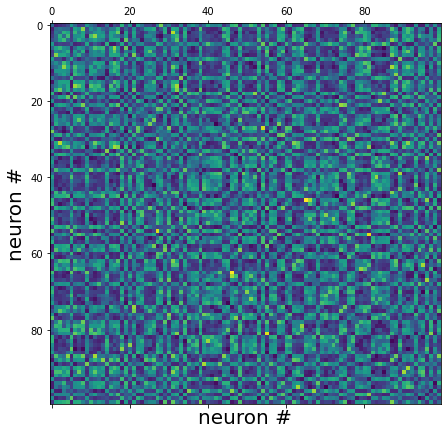

In [290]:
C=np.zeros((population_vector.shape[0],population_vector.shape[0]))
for i in range(population_vector.shape[0]):
    for j in range(population_vector.shape[0]):
            C[i][j]=pearsonr(population_vector[i],population_vector[j])[0]
figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(7,7))
ax.matshow(C-identity(population_vector.shape[0]),aspect="auto")
xlabel("neuron #",fontsize=20);
ylabel("neuron #",fontsize=20);

It is difficult to tell by eye if some structure is present in this data.  
Let's know use Kmeans on the correlation matrix, to see if there are clusters of neurons with correlated activity.  
First, let's use the cluster metrics to determine which number of cluster to use in the algorithm.

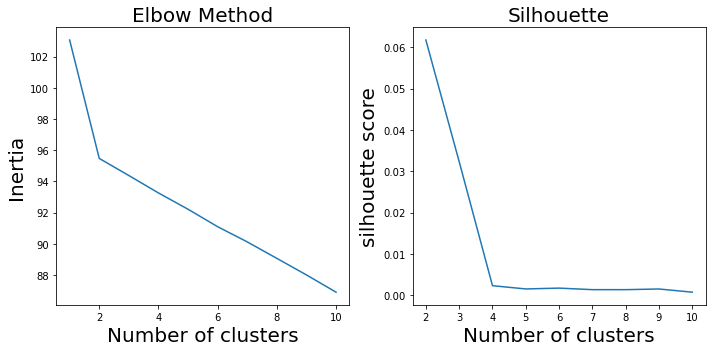

In [291]:
figure(figsize=(10,5))

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(C)
    inertia.append(kmeans.inertia_)
subplot(1,2,1)
plot(range(1, 11), inertia)
title('Elbow Method',fontsize=20)
xlabel('Number of clusters',fontsize=20)
ylabel('Inertia',fontsize=20)


s_score = []
for i in range(2,11):      
    kmeans = KMeans(n_clusters=i, init='k-means++')
    labels=kmeans.fit_predict(C)
    s_score.append(silhouette_score(C,labels))

subplot(1,2,2)
plot(range(2,11), s_score)
title('Silhouette' ,fontsize=20)
xlabel('Number of clusters',fontsize=20)
ylabel('silhouette score',fontsize=20)

tight_layout()

It looks like two clusters give the best description of the data. Let's now fit the data with two clusters, and assign each cell to one of them.

In [292]:
kmeans = KMeans(n_clusters=2, init='k-means++',random_state=0)
labels=kmeans.fit_predict(C)

Our data lives in a high dimensional space, but we can use PCA to look at how the clusters look like in the three-dimensional subspace spanned by the frist three PCs. 
Let's find the first three PCs of the correlation matrix, project the data in that space and plot it, color coded with the cluster labels:

Text(0.5, 0, 'PC 3')

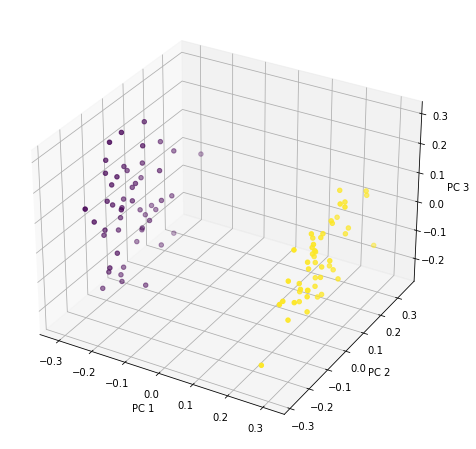

In [293]:
pca= PCA(n_components=3)                      
pca_results=pca.fit_transform(C)
x=pca_results.T[0]
y=pca_results.T[1]
z=pca_results.T[2]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d') 
ax.scatter(x, y, z,c=labels)  # let's color the datapoints with their time, to visualize the temporal evolution of the population dynamics 
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

The clustering we found does seem to capture well the structure of the data: it has uncovered two assemblies of neurons, that tend to co-fire together. 
We can use now the cluster labels to reorder the neurons before plotting their activity, grouping toghether all neurons belonging to the same clusters.

Text(0, 0.5, 'neuron #')

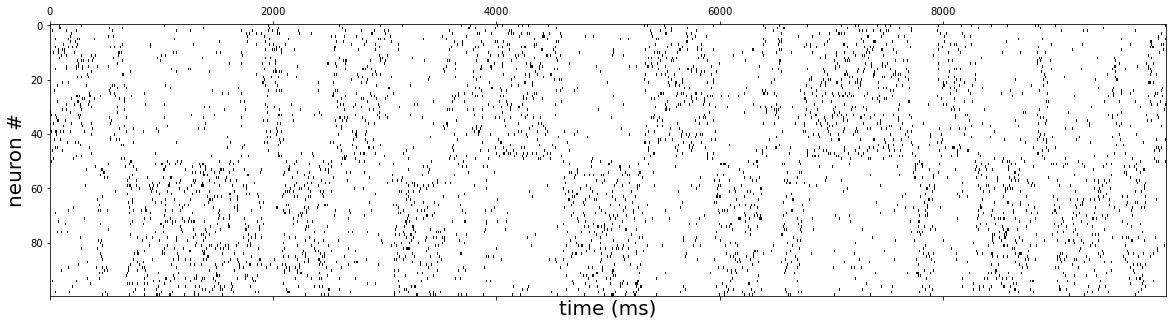

In [294]:
ix = np.argsort(labels)
ordered_population_vector=population_vector[ix]

fig, ax = plt.subplots(figsize=(20,5))
ax.matshow(ordered_population_vector, aspect='auto',cmap=cm.binary,vmax=0.1)
xlabel("time (ms)",fontsize=20)
ylabel("neuron #",fontsize=20)


Note that we are plotting the same population activity as our first plot, just oredered differently. The clustering tecniques helped us uncover some structure in the data: in this case the population is split in two assemblies, that alternate in periods of high and low activity. The same can be seen on the correlation matrix, using the same reordering:

<Figure size 720x720 with 0 Axes>

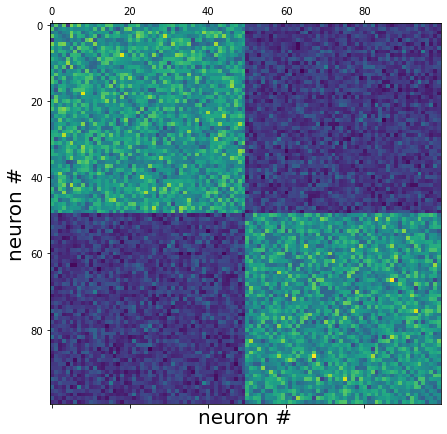

In [295]:
figure(figsize=(10,10))
ordered_C=np.zeros((ordered_population_vector.shape[0],ordered_population_vector.shape[0]))
for i in range(ordered_population_vector.shape[0]):
    for j in range(ordered_population_vector.shape[0]):
            ordered_C[i][j]=C[i][j]=pearsonr(ordered_population_vector[i],ordered_population_vector[j])[0]
            
fig, ax = plt.subplots(figsize=(7,7))
ax.matshow(ordered_C-identity(ordered_population_vector.shape[0]),aspect="auto")
xlabel("neuron #",fontsize=20);
ylabel("neuron #",fontsize=20);

Now it's your turn to try to detect co-active cell assemblies with k-means:

**Question 11.** Import the dataset "assemblies_exercises.npy". Calculate the correlation matrix and plot it, along with the population activity over time.

**Question 12.** Use the Kmeans algorithm and the clustering metrics to see what number of clusters could describe best the structure of the correlation matrix. 

**Question 13.** Fit the data to the number of clusters you determined in question 12. Use PCA to plot the data on a three dimensional space, color coded with te cluster labels.

**Question 14.** Use the cluster labels to reorder the population vector and plot the activity and the correlation matrix in this new order. How would you describe the behaviour of the neural population?  